In [1]:
import matplotlib.pyplot as plt
import os
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-21'
from straindesign import compress_model, remove_dummy_bounds
import cobra
import logging
logging.basicConfig(level=logging.INFO)
import cobra
import numpy as np


In [2]:
import straindesign as sd
import straindesign.names as names

In [3]:
from syn_elong import model
from syn_elong.media import m9_media

Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Set parameter GURO_PAR_SPECIAL


INFO:gurobipy.gurobipy:Set parameter GURO_PAR_SPECIAL


Set parameter TokenServer to value "leghorn"


INFO:gurobipy.gurobipy:Set parameter TokenServer to value "leghorn"


In [4]:
with model:
    print(model.slim_optimize())

0.05390186774577662


In [5]:
with model:
    model.medium = m9_media
    print(model.slim_optimize())

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


4.088280273582626


In [12]:
with model:
    model.medium = m9_media
#     model.reactions.BIOMASS__1.upper_bound = 1000
#     model.objective = 'BIOMASS__1'
#     sol = model.optimize()
    sol = sd.fba(model, obj='BIOMASS__1', obj_sense='max', pfba =False)
    print(f"Maximum possible BIOMASS__1 synthesis rate: {sol.objective_value}.")
#     x = sol.to_frame()
#     display(x.sort_values(by='reduced_costs', ascending=True))
#     print(x.loc['EX_sucr_e'])
    sol = sd.fba(model, obj='EX_sucr_e', obj_sense='max', pfba =False)
    print(f"Maximum possible EX_sucr_e synthesis rate: {sol.objective_value}.")
#     model.objective = 'EX_sucr_e'
#     sol = model.optimize()
    
#     x = sol.to_frame()
#     display(x.sort_values(by='reduced_costs', ascending=True))
#     print(x.loc['BIOMASS__1'])

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


Maximum possible BIOMASS__1 synthesis rate: 4.088280273582666.
Maximum possible EX_sucr_e synthesis rate: 16.389121923937367.


In [28]:
model.medium = m9_media

INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


INFO:cobra.medium.boundary_types:Compartment `e` sounds like an external compartment. Using this one without counting boundary reactions.


In [12]:
len(model.reactions)

999

In [29]:
model.summary()

INFO:cobra.summary.model_summary:Generating new parsimonious flux distribution.


Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,77.95,1,43.80%
cobalt2_e,EX_cobalt2_e,2.092E-05,0,0.00%
fe3_e,EX_fe3_e,0.006549,0,0.00%
h_e,EX_h_e,69.13,0,0.00%
hco3_e,EX_hco3_e,100,1,56.20%
k_e,EX_k_e,6.325E-06,0,0.00%
mg2_e,EX_mg2_e,0.04583,0,0.00%
na1_e,EX_na1_e,4.865E-07,0,0.00%
nh4_e,EX_nh4_e,32.95,0,0.00%
photon510_e,EX_photon510_e,13.46,0,0.00%


In [30]:
fluxes = model.optimize().fluxes
fluxes = fluxes[np.abs(fluxes)>0]

In [31]:
ex = [i for i in fluxes.index if i.startswith('EX_')]

In [32]:
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [33]:
# fluxes.style.format('{:.2f}', na_rep='MISS')
fluxes.loc[ex].sort_values()

EX_photon690_e   -1000.000
EX_photon670_e   -1000.000
EX_hco3_e         -100.000
EX_co2_e           -77.949
EX_h_e             -69.129
EX_nh4_e           -32.949
EX_photon470_e     -13.457
EX_pi_e             -1.744
EX_so4_e            -0.637
EX_mg2_e            -0.046
EX_photon650_e      -0.046
EX_fe3_e            -0.007
EX_cobalt2_e        -0.000
EX_k_e              -0.000
EX_na1_e            -0.000
EX_sucr_e            0.011
EX_h2o_e             9.316
EX_o2_e            194.131
Name: fluxes, dtype: float64

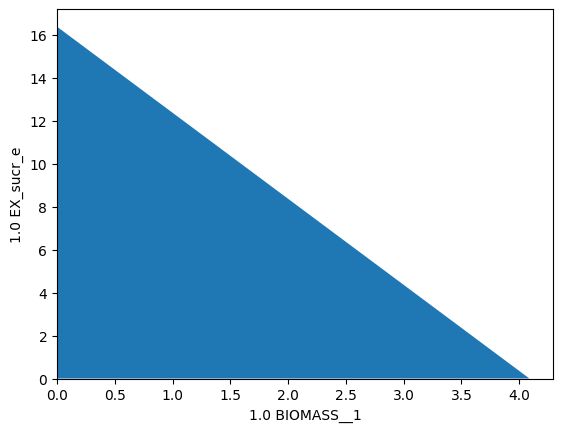

In [34]:

datapoints, triang, plot1 = sd.plot_flux_space(
    model,
    ('BIOMASS__1','EX_sucr_e'),
    show=False
);

In [35]:
blocked_reactions = cobra.flux_analysis.find_blocked_reactions(model)

In [36]:
len(blocked_reactions)

235

In [37]:
consistent_model = cobra.flux_analysis.fastcc(model)
cobra.io.write_sbml_model( consistent_model, 'condensed_syn.xml',)

Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpm59iakji.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\pino216\AppData\Local\Temp\tmpm59iakji.lp


Reading time = 0.03 seconds


INFO:gurobipy.gurobipy:Reading time = 0.03 seconds


: 893 rows, 1952 columns, 7974 nonzeros


INFO:gurobipy.gurobipy:: 893 rows, 1952 columns, 7974 nonzeros


In [38]:
consistent_model.summary(fva=.9)

INFO:cobra.summary.model_summary:Generating new parsimonious flux distribution.
INFO:cobra.summary.model_summary:Performing flux variability analysis.


Metabolite,Reaction,Flux,Range,C-Number,C-Flux
co2_e,EX_co2_e,77.95,[60.17; 100],1,43.80%
cobalt2_e,EX_cobalt2_e,2.092E-05,[1.883E-05; 2.076E-05],0,0.00%
fe3_e,EX_fe3_e,0.006549,[0.005894; 0.006549],0,0.00%
h_e,EX_h_e,69.13,[32.37; 100],0,0.00%
hco3_e,EX_hco3_e,100,[60.17; 100],1,56.20%
k_e,EX_k_e,6.325E-06,[5.692E-06; 6.325E-06],0,0.00%
mg2_e,EX_mg2_e,0.04583,[0.04125; 0.04583],0,0.00%
na1_e,EX_na1_e,4.865E-07,[4.379E-07; 4.865E-07],0,0.00%
nh4_e,EX_nh4_e,32.95,[15.11; 32.95],0,0.00%
photon470_e,EX_photon470_e,13.46,[0; 1000],0,0.00%


In [39]:
consistent_model.slim_optimize()

4.088280273582658

In [40]:
model.slim_optimize()

4.088280273582654

In [41]:
for rxn in consistent_model.metabolites.sucr_c.reactions:
    print(rxn)
    # print(consistent_model.reactions.get_by_id(rxn.id))

SPP: h2o_c + suc6p_c --> pi_c + sucr_c
SUCRt2: h_e + sucr_e <=> h_c + sucr_c
SUCR: h2o_c + sucr_c --> fru_c + glc__D_c


In [42]:
consistent_model.metabolites.suc6p_c

Metabolite identifier,suc6p_c
Name,Sucrose 6-phosphate
Memory address,0x01babb3f1330
Formula,C12H21O14P
Compartment,c
In 2 reaction(s),"SPP, SPS"


In [ ]:
for rxn in consistent_model.metabolites.suc6p_c.reactions:
    print(rxn)

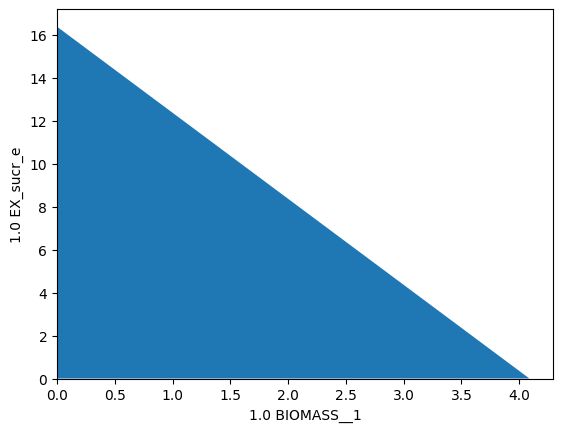

In [44]:

datapoints, triang, plot1 = sd.plot_flux_space(
    consistent_model,
    ('BIOMASS__1','EX_sucr_e'),
    show=False
);

In [45]:
module_optknock = sd.SDModule(
    consistent_model,
    names.OPTKNOCK,
    inner_objective='BIOMASS__1',
    outer_objective='EX_sucr_e',
    constraints=['EX_sucr_e >= 5', 'BIOMASS__1 >= 1.']
)

In [49]:
import logging
logging.basicConfig(level=logging.INFO)

sols = sd.compute_strain_designs(
    consistent_model,
    sd_modules = module_optknock,
    max_solutions = 1,
    max_cost = 3,
    solution_approach = 'best',
    time_limit=300,

)

INFO:root:Preparing strain design computation.
INFO:root:  Using gurobi for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.


Exception: Status code 12 not yet handeld.

In [83]:
import networkx as nx

In [ ]:
rxn_graph = nx.DiGraph()
for i in reaction_sd:
    prev = None
    for j in i:
        if prev is not None:
            rxn_graph.add_edge(prev, j)
        prev = j
            
#     print(i)
nx.draw_networkx(rxn_graph, pos=nx.layout.kamada_kawai_layout(rxn_graph, rxn_graph.nodes))

In [97]:
nx.write_gml(rxn_graph, 'reaction_graph.gml')

In [ ]:
reaction_sd = [
     {'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PGCD': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSERT': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSP_L': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PGCD': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSERT': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'GND': -1.0, 'PGCD': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'GND': -1.0, 'PSERT': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'PGL': -1.0, 'PSP_L': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'PGL': -1.0, 'PGCD': -1.0},
     {'GART': -1.0, 'PDH': -1.0, 'PGL': -1.0, 'PSERT': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0, 'SFGTHi': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PGCD': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PGCD': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PGCD': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PGCD': -1.0, 'SFGTHi': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSERT': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSERT': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSERT': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'GND': -1.0, 'PSERT': -1.0, 'SFGTHi': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSP_L': -1.0, 'SFGTHi': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PGCD': -1.0, 'SFGTHi': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'G6PDH2r': -1.0, 'PSERT': -1.0, 'SFGTHi': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSP_L': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSP_L': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSP_L': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSP_L': -1.0, 'SFGTHi': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PGCD': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PGCD': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PGCD': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PGCD': -1.0, 'SFGTHi': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSERT': -1.0, 'FALGTHLs': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSERT': -1.0, 'FALDH2': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSERT': -1.0, 'ALCD1': -1.0},
     {'PDH': -1.0, 'PGL': -1.0, 'PSERT': -1.0, 'SFGTHi': -1.0}
]

In [142]:
reaction_sd[0]

{'PDH': -1.0, 'GND': -1.0, 'PSP_L': -1.0}

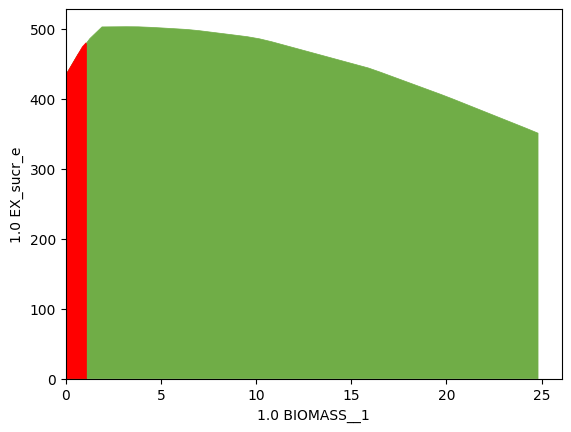

In [143]:
consistent_model.reactions.BIOMASS__1.upper_bound = 10000
datapoints, triang, plot1 = sd.plot_flux_space(
    consistent_model,
    ('BIOMASS__1', 'EX_sucr_e'),
    show=False
);

plot1.set_facecolor('#70AD47')
plot1.set_edgecolor('#70AD47')

# OptKnock design plot
# interventions = [[{s:1.0},'=',0.0] for rxn in reaction_sd for s,v in rxn.items() if v < 1]
interventions = [[{s:1.0},'=', 0.0] for s,v in reaction_sd[2].items() if v < 1]
_, _,plot3 = sd.plot_flux_space(
    consistent_model,
    ('BIOMASS__1', 'EX_sucr_e'),
    # The sign of the glucose exchange reaction is flipped since
    # reaction is defined in the direction of secretion.
    constraints=interventions,
    show=False
);
plot3.set_facecolor('red')
plot3.set_edgecolor('red')
# adjust axes limits and show plot
plot3.axes.set_xlim(0, 1.05*max([a[0] for a in datapoints]))
plot3.axes.set_ylim(0, 1.05*max([a[1] for a in datapoints]))
plt.show()

In [110]:
print(interventions)
#rxns = set()
#for i in sols.reaction_sd:
#    for j in i:
#        rxns.add(j)
#print(rxns)

[[{'PDH': 1.0}, '=', 0.0], [{'GND': 1.0}, '=', 0.0], [{'PSP_L': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'GND': 1.0}, '=', 0.0], [{'PGCD': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'GND': 1.0}, '=', 0.0], [{'PSERT': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'G6PDH2r': 1.0}, '=', 0.0], [{'PSP_L': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'G6PDH2r': 1.0}, '=', 0.0], [{'PGCD': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'G6PDH2r': 1.0}, '=', 0.0], [{'PSERT': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'PGL': 1.0}, '=', 0.0], [{'PSP_L': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'PGL': 1.0}, '=', 0.0], [{'PGCD': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'PGL': 1.0}, '=', 0.0], [{'PSERT': 1.0}, '=', 0.0], [{'GART': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'GND': 1.0}, '=', 0.0], [{'PSP_L': 1.0}, '=', 0.0], [{'GART': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'GND': 1.0}, '=', 0.0], [{'PGCD': 1.0}, '=', 0.0], [{'GART': 1.0}, '=', 0.0], [{'PDH': 1.0}, '=', 0.0], [{'G

In [ ]:
rxn_to_remove = {
    'PSERT', 'ALCD1', 'PGL', 'SFGTHi',
    'G6PDH2r', 'FALDH2', 
    'PSP_L', 'GART', 'PGCD', 
    'GND', 'FALGTHLs', 'PDH'
}
rxn_to_remove

In [111]:
for i in rxn_to_remove:
    rxn = model.reactions.get_by_id(i)
    print(i, {gene.id for gene in rxn.genes})


SFGTHi {'SYNPCC7942_RS02335'}
GART {'SYNPCC7942_RS03015'}
G6PDH2r {'SYNPCC7942_RS11865'}
ALCD1 {'SYNPCC7942_RS08430', 'SYNPCC7942_RS11615'}
PGCD {'SYNPCC7942_RS07670'}
GND {'SYNPCC7942_RS00195'}
FALGTHLs set()
PDH {'SYNPCC7942_RS00725', 'SYNPCC7942_RS05480', 'SYNPCC7942_RS06135', 'SYNPCC7942_RS09865'}
PGL {'SYNPCC7942_RS02690'}
PSP_L {'SYNPCC7942_RS02470'}
FALDH2 {'SYNPCC7942_RS02340'}
PSERT {'SYNPCC7942_RS00970'}


In [ ]:
ex=ex+['BIOMASS__1']

In [100]:
gene = model.genes.get_by_id('SYNPCC7942_RS03015')

In [104]:
model.reactions.get_by_id('GART')

Reaction identifier,GART
Name,GAR transformylase-T
Memory address,0x0234527f9ed0
Stoichiometry,atp_c + for_c + gar_c --> adp_c + fgam_c + h_c + pi_c ATP C10H12N5O13P3 + Formate + N1-(5-Phospho-D-ribosyl)glycinamide --> ADP C10H12N5O10P2 + N2-Formyl-N1-(5-phospho-D-ribosyl)glycinamide + H+ + Phosphate
GPR,SYNPCC7942_RS03015
Lower bound,0.0
Upper bound,1000.0


In [113]:
with model as model:
    model.objective = {model.reactions.get_by_id('EX_sucr_e'): 1, model.reactions.get_by_id('BIOMASS__1'):1}
    print(model.slim_optimize())
    for i in rxn_to_remove:
        model.remove_reactions([model.reactions.get_by_id(i)])
    model.genes.get_by_id('SYNPCC7942_RS03015').knock_out()    
    model.objective = {model.reactions.get_by_id('EX_sucr_e'): 1, model.reactions.get_by_id('BIOMASS__1'):1}
    print(model.slim_optimize())
    pfba_solution = cobra.flux_analysis.pfba(model)
    print(pfba_solution)
    fluxes = pfba_solution.fluxes
    prices = pfba_solution.shadow_prices

522.3691291212901
480.5486028819524
<Solution 26559.255 at 0x23457146260>


In [43]:
cobra.io.save_json_model( model, 'name_for_now.json',)

In [34]:
import escher
from escher import Builder

In [35]:
builder = Builder()

In [40]:
builder.model = model

In [44]:
builder.metabolite_data = pfba_solution.shadow_prices
builder.reaction_data = pfba_solution.fluxes

In [42]:
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

In [58]:
with model:
    model.objective = {model.reactions.get_by_id('EX_sucr_e'): 1, model.reactions.get_by_id('BIOMASS__1'):5}
    pfba_solution = cobra.flux_analysis.pfba(model)
builder.metabolite_data = pfba_solution.shadow_prices
builder.reaction_data = pfba_solution.fluxes

In [47]:
flux = pfba_solution.fluxes.to_dict()

## Auto escher map

This code is based on https://github.com/johncthomas/Auto-Escher-map-for-CobraPy.
It doesn't quite do the visualization as wanted, but I'll keep it here until I get a defined escher map working right.

In [45]:
import generate_emap

In [56]:
excluded_reactions = set(ex)

common_mets = set()
rxn_with_flux = set()
rxn_with_greater_flux = set()

threshold_flux = 1.1

# Get a list of reactions with flux and those where flux exceeds the threshold
# The rxn_with_flux will be used to determine what's a common metabolite
# rxn_with_greater flux used to draw the map
for rxn_name in flux:
    if flux[rxn_name] != 0 and rxn_name not in excluded_reactions:
        rxn = model.reactions.get_by_id(rxn_name)
        rxn_with_flux.add(rxn)
        if 0-threshold_flux > flux[rxn_name] or threshold_flux < flux[rxn_name]:
            rxn_with_greater_flux.add(rxn)

# Get a dictionary of metabolite frequency
# (keys are the Cobra metabolite objects)
met_count = generate_emap.metabolite_occurence(rxn_with_flux)

# Get common metabolites.
# included_common_m will be used be treated as uncommon whatever their occurence
included_common_m = ('accoa_c', 'pry_c', 'g3p_c', 'acald_c', 'f6p_c', 'pep_c')
for met in met_count:
    if met_count[met] > 25 and met.id not in included_common_m:
        common_mets.add(met)

# Convert the sets to lists so that they can be iterated over
common_mets, rxn_with_flux, rxn_with_greater_flux = \
    list(common_mets), list(rxn_with_flux), list(rxn_with_greater_flux)


# Get the Escher JSON
escher_map = generate_emap.gen_map(
     consistent_model, rxn_with_greater_flux,  common_mets, 400, met_count
)
escher_json = escher_map.dump_json()
# Currently Escher doesn't accept json strings, needs a file, i assume that's a bug
with open('escher.json', 'w') as f:
    f.write(escher_json)

Of 98 reactions 75 have a link
The following are only connected to other reactions by common intermediates
Modeling: demand reaction (succ c) [DM_succ_c]::  succ_c --> 
Nitrate exchange [EX_no3_e]::  no3_e <=> 
Nucleoside-diphosphate kinase (ATP:GDP) [NDPK1]::  atp_c + gdp_c <=> adp_c + gtp_c
Adenylate kinase [ADK1]::  amp_c + atp_c <=> 2.0 adp_c
Polyphosphate kinase [PPK]::  atp_c + pi_c <=> adp_c + ppi_c
Modeling: exchange reaction, photon absorption (680-700nm)  [EX_photon690_e]::  photon690_e <=> 
Modeling: exchange reaction, photon absorption (660nm-680nm)  [EX_photon670_e]::  photon670_e <=> 
H2O transport via diffusion (tilacoid) [H2Otu_syn]::  h2o_u <=> h2o_c
Modeling: exchange reaction, photon absorption (500nm-520nm) [EX_photon510_e]::  photon510_e <=> 
Acetate kinase [ACKr]::  ac_c + atp_c <=> actp_c + adp_c
Sucrose transport in via proton symport [SUCRt2]::  h_e + sucr_e <=> h_c + sucr_c
Sedoheptulose-bisphosphatase [SBP]::  h2o_c + s17bp_c --> pi_c + s7p_c
Unconnected coun

In [53]:
builder.hide_secondary_metabolites = True

In [54]:
rxn_to_remove

{'ALCD1',
 'FALDH2',
 'FALGTHLs',
 'G6PDH2r',
 'GART',
 'GND',
 'PDH',
 'PGCD',
 'PGL',
 'PSERT',
 'PSP_L',
 'SFGTHi'}

In [51]:
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…